In [12]:
from os import listdir
from os.path import isdir

from PIL import Image
from matplotlib import pyplot

from numpy import savez_compressed
from numpy import asarray
from numpy import load
from numpy import expand_dims

from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

import import_ipynb
import google_sheets_api as gpi

import pickle
model = pickle.loads(open('facenet_model', "rb").read())

dataset_folder = 'Celebrity Faces Dataset'
facenet_model = load_model('keras-facenet/model/facenet_keras.h5', compile=False)

data = load('5-celebrity-faces-embeddings.npz')
labels = data['arr_1']

In [17]:
# create the detector, using default weights
detector = MTCNN()
    
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

def run(embedding, image):
    # prediction for the face
    samples = expand_dims(embedding, axis=0)
    yhat_class = model.predict(samples)
    yhat_prob = model.predict_proba(samples)

    out_encoder = LabelEncoder()
    out_encoder.fit(labels)

    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    
    gpi.upload_data(gpi.spreadsheet_id, [[predict_names[0], class_probability]])

    # plot for fun
    pyplot.imshow(image)
    title = '%s (%.3f)' % (predict_names[0], class_probability)
    pyplot.title(title)
    pyplot.show()

Predicted: ben_afflek (86.677)


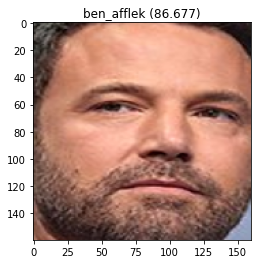

Predicted: madonna (29.649)


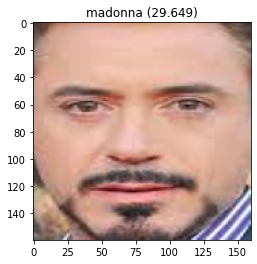

Predicted: elton_john (54.595)


In [ ]:
test_folder = 'test/'
test_arrays = load_faces(test_folder)

test_embedding = list()
for face_pixels in test_arrays:
	embedding = get_embedding(facenet_model, face_pixels)
	test_embedding.append(embedding)
test_embedding = asarray(test_embedding)

in_encoder = Normalizer(norm='l2')
test_embedding = in_encoder.transform(test_embedding)

for embedding, image in zip(test_embedding, test_arrays):
    run(embedding, image)